# Cross Validation - In-hospital Mortality Prediction (Optimism Error)
**contact:** drew.wilimitis@vumc.org

## Import Libraries

In [1]:
# import libraries
import matplotlib.pyplot as plt
import scienceplots
import sys
import os
import numpy as np
import pandas as pd
import seaborn as sns
import json

# set matplotlib style and plotting configuration

plt.style.use('seaborn')
%matplotlib inline

# ignore warnings
import warnings
warnings.filterwarnings('ignore');

# display multiple outputs within a cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all";

## Load Data & Prepare for Modeling

In [2]:
# load processed input data
data = pd.read_csv('../data/MIMIC3_FULL_PROCESSED_DATASET_20221022.csv')
data.head()
data.shape
data.SUBJECT_ID.nunique()
data.HADM_ID.nunique()
data.ICUSTAY_ID.nunique()
print(list(data.columns))
data.isna().sum().sort_values(ascending=False)
data.dtypes

,SUBJECT_ID,HADM_ID,ICUSTAY_ID,ADMITTIME,DISCHTIME,ETHNICITY,GENDER,AGE,LOS_STAY_LABEL,MORTALITY_STAY_LABEL,...,ADMIT_DIAG_CEREBROVASCULAR ACCIDENT,ADMIT_DIAG_SEPSIS,ADMIT_DIAG_HYPOXIA,ADMIT_DIAG_RESPIRATORY DISTRESS,GENDER_MALE,RACE_WHITE,RACE_HISPANIC,RACE_BLACK,RACE_ASIAN,RACE_OTHER_UNKNOWN
0,50447,127105,253123,2164-06-17 03:06:00,2164-06-24 13:00:00,WHITE,F,53.719370,1.4437,0,...,0,0,0,0,0,1,0,0,0,0
1,78238,195560,224253,2150-09-29 21:20:00,2150-10-01 14:00:00,WHITE,F,77.275838,0.8005,0,...,0,0,0,0,0,1,0,0,0,0
2,78238,148934,259839,2150-10-23 10:43:00,2150-10-28 12:34:00,WHITE,F,77.341547,2.4825,0,...,0,0,0,0,0,1,0,0,0,0
3,13966,166620,231548,2187-10-07 20:04:00,2187-10-10 14:44:00,WHITE,M,74.349076,0.9708,0,...,0,0,0,0,1,1,0,0,0,0
4,351,174800,281750,2171-07-16 23:13:00,2171-07-25 19:36:00,BLACK/AFRICAN AMERICAN,F,51.071869,3.8597,0,...,0,0,0,0,0,0,0,1,0,0


(41121, 70)

33281

41121

41121

['SUBJECT_ID', 'HADM_ID', 'ICUSTAY_ID', 'ADMITTIME', 'DISCHTIME', 'ETHNICITY', 'GENDER', 'AGE', 'LOS_STAY_LABEL', 'MORTALITY_STAY_LABEL', 'MORTALITY_INHOSPITAL_STAY_LABEL', 'ETHNICITY_NUM', 'GENDER_NUM', 'HEIGHT', 'WEIGHT', 'LOS_EPISODE_LABEL', 'MORTALITY_EPISODE_LABEL', 'HOURS', 'CAPILLARY REFILL RATE', 'DIASTOLIC BLOOD PRESSURE', 'FRACTION INSPIRED OXYGEN', 'GLASCOW COMA SCALE TOTAL', 'GLUCOSE', 'HEART RATE', 'HEIGHT.1', 'MEAN BLOOD PRESSURE', 'OXYGEN SATURATION', 'RESPIRATORY RATE', 'SYSTOLIC BLOOD PRESSURE', 'TEMPERATURE', 'WEIGHT.1', 'PH', 'SEPTICEMIA (EXCEPT IN LABOR)', 'DIABETES MELLITUS WITHOUT COMPLICATION', 'DIABETES MELLITUS WITH COMPLICATIONS', 'DISORDERS OF LIPID METABOLISM', 'FLUID AND ELECTROLYTE DISORDERS', 'ESSENTIAL HYPERTENSION', 'HYPERTENSION WITH COMPLICATIONS AND SECONDARY HYPERTENSION', 'ACUTE MYOCARDIAL INFARCTION', 'CORONARY ATHEROSCLEROSIS AND OTHER HEART DISEASE', 'CONDUCTION DISORDERS', 'CARDIAC DYSRHYTHMIAS', 'CONGESTIVE HEART FAILURE; NONHYPERTENSIVE', 'AC

CAPILLARY REFILL RATE                                         40475
HEIGHT                                                        31792
HEIGHT.1                                                      31784
FRACTION INSPIRED OXYGEN                                      30697
GLASCOW COMA SCALE TOTAL                                      18524
                                                              ...  
ESSENTIAL HYPERTENSION                                            0
HYPERTENSION WITH COMPLICATIONS AND SECONDARY HYPERTENSION        0
ACUTE MYOCARDIAL INFARCTION                                       0
CORONARY ATHEROSCLEROSIS AND OTHER HEART DISEASE                  0
RACE_OTHER_UNKNOWN                                                0
Length: 70, dtype: int64

SUBJECT_ID             int64
HADM_ID                int64
ICUSTAY_ID             int64
ADMITTIME             object
DISCHTIME             object
                       ...  
RACE_WHITE             int64
RACE_HISPANIC          int64
RACE_BLACK             int64
RACE_ASIAN             int64
RACE_OTHER_UNKNOWN     int64
Length: 70, dtype: object

In [3]:
# run cv experiements with selected features for mortality prediction
race_cols = [x for x in data.columns if 'RACE' in x]
data['GENDER_FEMALE'] = data.GENDER.apply(lambda x: 1 if x=='F' else 0)
dem_cols = ['GENDER_MALE', 'GENDER_FEMALE', 'AGE'] + race_cols
drop_cols = ['SUBJECT_ID', 'HADM_ID', 'ICUSTAY_ID', 'ADMITTIME', 'DISCHTIME', 'ETHNICITY', 'GENDER']
label_cols = [x for x in data.columns if 'LABEL' in x]
print(race_cols)
print(dem_cols)
print(label_cols)

X = data.drop(drop_cols + label_cols, axis=1)
X.shape
y = data['MORTALITY_INHOSPITAL_STAY_LABEL']
y.shape
np.any(X.isna())
np.mean(y)
y.value_counts()

['RACE_WHITE', 'RACE_HISPANIC', 'RACE_BLACK', 'RACE_ASIAN', 'RACE_OTHER_UNKNOWN']
['GENDER_MALE', 'GENDER_FEMALE', 'AGE', 'RACE_WHITE', 'RACE_HISPANIC', 'RACE_BLACK', 'RACE_ASIAN', 'RACE_OTHER_UNKNOWN']
['LOS_STAY_LABEL', 'MORTALITY_STAY_LABEL', 'MORTALITY_INHOSPITAL_STAY_LABEL', 'LOS_EPISODE_LABEL', 'MORTALITY_EPISODE_LABEL']


(41121, 59)

(41121,)

True

0.10505581089954039

0    36801
1     4320
Name: MORTALITY_INHOSPITAL_STAY_LABEL, dtype: int64

In [4]:
# defining column types for pre-processing
binary_dem_cols = ['GENDER_MALE', 'GENDER_FEMALE', 'RACE_WHITE', 'RACE_HISPANIC', 'RACE_BLACK',
                   'RACE_ASIAN', 'RACE_OTHER_UNKNOWN']
binary_diag_cols = ['Septicemia (except in labor)', 'Diabetes mellitus without complication',
                    'Diabetes mellitus with complications', 'Disorders of lipid metabolism',
                    'Fluid and electrolyte disorders', 'Essential hypertension',
                    'Hypertension with complications and secondary hypertension', 'Acute myocardial infarction',
                    'Coronary atherosclerosis and other heart disease', 'Conduction disorders', 'Cardiac dysrhythmias',
                    'Congestive heart failure; nonhypertensive', 'Acute cerebrovascular disease',
                    'Pneumonia (except that caused by tuberculosis or sexually transmitted disease)',
                    'Chronic obstructive pulmonary disease and bronchiectasis', 'Pleurisy; pneumothorax; pulmonary collapse',
                    'Respiratory failure; insufficiency; arrest (adult)', 'Other lower respiratory disease',
                    'Other upper respiratory disease', 'Other liver diseases', 'Gastrointestinal hemorrhage',
                    'Acute and unspecified renal failure', 'Chronic kidney disease',
                    'Complications of surgical procedures or medical care', 'Shock']
binary_admit_cols = ['ADMIT_DIAG_CARDIAC_ARREST', 'ADMIT_DIAG_BRAIN_HEMORRHAGE', 'ADMIT_DIAG_LIVER FAILURE',
                     'ADMIT_DIAG_CEREBROVASCULAR ACCIDENT', 'ADMIT_DIAG_SEPSIS', 'ADMIT_DIAG_HYPOXIA',
                     'ADMIT_DIAG_RESPIRATORY DISTRESS']
dem_cont_cols = ['AGE', 'HEIGHT', 'WEIGHT']
meas_cont_cols = ['Capillary refill rate', 'Diastolic blood pressure',
                  'Fraction inspired oxygen', 'Glascow coma scale total', 'Glucose', 'Heart Rate',
                  'Mean blood pressure', 'Oxygen saturation', 'Respiratory rate',
                  'Systolic blood pressure', 'Temperature', 'pH']

# rename sets of feature columns
X.columns = [x.upper() for x in X.columns if x not in meas_cont_cols]
binary_dem_cols = [x.upper() for x in binary_dem_cols]
binary_diag_cols = [x.upper() for x in binary_diag_cols]
binary_admit_cols = [x.upper() for x in binary_admit_cols]
dem_cont_cols = [x.upper() for x in dem_cont_cols]

# describe feature ranges
col_sets = [binary_dem_cols, binary_diag_cols, binary_admit_cols, dem_cont_cols]
names = ['Demographics', 'CCS Diagnoses', 'Primary Admission Reason', 'Measurement Variables']

In [5]:
# examine new feature covariate data
X.head()
X.shape
X.dtypes
y.isna().sum()

,AGE,ETHNICITY_NUM,GENDER_NUM,HEIGHT,WEIGHT,HOURS,CAPILLARY REFILL RATE,DIASTOLIC BLOOD PRESSURE,FRACTION INSPIRED OXYGEN,GLASCOW COMA SCALE TOTAL,...,ADMIT_DIAG_SEPSIS,ADMIT_DIAG_HYPOXIA,ADMIT_DIAG_RESPIRATORY DISTRESS,GENDER_MALE,RACE_WHITE,RACE_HISPANIC,RACE_BLACK,RACE_ASIAN,RACE_OTHER_UNKNOWN,GENDER_FEMALE
0,53.719370,4,1,163.0,70.397478,33.374167,NaN,65.000000,0.500,NaN,...,0,0,0,0,1,0,0,0,0,1
1,77.275838,4,1,163.0,77.155999,17.868333,NaN,48.800000,NaN,NaN,...,0,0,0,0,1,0,0,0,0,1
2,77.341547,4,1,155.0,77.836387,58.261944,NaN,53.986301,0.625,NaN,...,0,0,0,0,1,0,0,0,0,1
3,74.349076,4,2,NaN,NaN,21.916667,NaN,53.068966,NaN,13.75,...,0,0,0,1,1,0,0,0,0,0
4,51.071869,2,1,NaN,208.000000,89.316667,NaN,72.369565,NaN,15.00,...,0,0,0,0,0,0,1,0,0,1


(41121, 59)

AGE                                                                               float64
ETHNICITY_NUM                                                                       int64
GENDER_NUM                                                                          int64
HEIGHT                                                                            float64
WEIGHT                                                                            float64
HOURS                                                                             float64
CAPILLARY REFILL RATE                                                             float64
DIASTOLIC BLOOD PRESSURE                                                          float64
FRACTION INSPIRED OXYGEN                                                          float64
GLASCOW COMA SCALE TOTAL                                                          float64
GLUCOSE                                                                           float64
HEART RATE

0

In [6]:
# set outlier age/weight/height values to NA for imputation
X.loc[(X.AGE > 110), 'AGE'] = np.nan
X.loc[(X.WEIGHT == 0), 'WEIGHT'] = np.nan
X.loc[(X.HEIGHT==0), 'HEIGHT'] = np.nan

# check for negative values and plot missingness
np.sum(X.fillna(0).min() < 0)
null_counts = pd.DataFrame(X.isna().mean().reset_index())
null_counts.columns = ['feature', 'pct_na']
null_counts = null_counts.sort_values(by='pct_na', ascending=False)[:10]
null_counts[null_counts.pct_na < 1].shape
null_counts[null_counts.pct_na == 0].value_counts()

0

(10, 2)

Series([], dtype: int64)

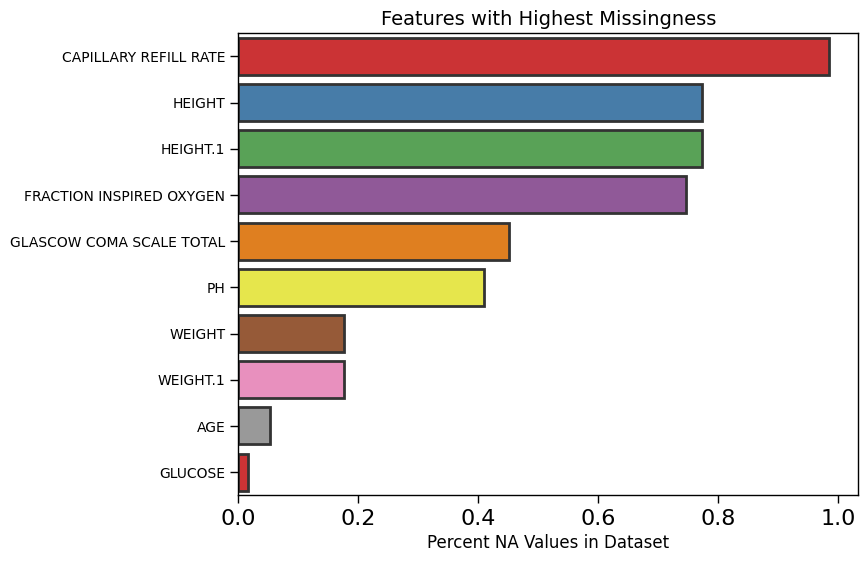

In [7]:
# plot barplot showing missingness
plt.style.reload_library()
plt.style.use('default')
plt.style.use(['nature', 'notebook', 'high-contrast', 'no-latex'])
plt.rcParams.update({   # specify font family here
    "font.monospace": "Terminal",  # specify font here
    "font.size":11})          # specify font size here

ax = plt.subplot(111)
sns.barplot(data=null_counts, x='pct_na', y='feature', orient='h', errcolor='black', palette='Set1',
            ax=ax, linewidth=2, edgecolor=".2", dodge=False)
plt.yticks(size=10)
plt.ylabel('')
plt.xlabel('Percent NA Values in Dataset', size=12);
plt.title('Features with Highest Missingness', size=14)
plt.show();

In [8]:
# finalize set of features to use for classification modeling
cont_cols = dem_cont_cols
binary_cols = binary_dem_cols + binary_diag_cols + binary_admit_cols
features = cont_cols + binary_cols

X_exp1 = X[features].copy()
y_exp1 = y.copy()
X_exp1.head()
X_exp1.shape

y_exp1.head()
y_exp1.shape
y_exp1.mean()

# fill in na values for cv modeling
X_exp1[binary_cols] = X_exp1[binary_cols].fillna(0)
y_exp1.fillna(0, inplace=True)

,AGE,HEIGHT,WEIGHT,GENDER_MALE,GENDER_FEMALE,RACE_WHITE,RACE_HISPANIC,RACE_BLACK,RACE_ASIAN,RACE_OTHER_UNKNOWN,...,CHRONIC KIDNEY DISEASE,COMPLICATIONS OF SURGICAL PROCEDURES OR MEDICAL CARE,SHOCK,ADMIT_DIAG_CARDIAC_ARREST,ADMIT_DIAG_BRAIN_HEMORRHAGE,ADMIT_DIAG_LIVER FAILURE,ADMIT_DIAG_CEREBROVASCULAR ACCIDENT,ADMIT_DIAG_SEPSIS,ADMIT_DIAG_HYPOXIA,ADMIT_DIAG_RESPIRATORY DISTRESS
0,53.719370,163.0,70.397478,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,77.275838,163.0,77.155999,0,1,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,77.341547,155.0,77.836387,0,1,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
3,74.349076,NaN,NaN,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,51.071869,NaN,208.000000,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


(41121, 42)

0    0
1    0
2    0
3    0
4    0
Name: MORTALITY_INHOSPITAL_STAY_LABEL, dtype: int64

(41121,)

0.10505581089954039

## Updated Optimism Experiment: Estimate Test Error from CV Performances

- Define 20% validation set and run CV on remaining 80% <br>
- Run CV with different methods and return best estimators <br>
- Predict on validation set with best CV estimator and compare results to within-CV metrics

**Analyses: Repeat Validation-CV Optimism Comparison over only 5-Folds**

In [9]:
# import additional libraries used by functions below
import scipy.stats as st
import joblib
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import StandardScaler, QuantileTransformer, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import SGDClassifier, RidgeClassifier
from sklearn.model_selection import KFold, StratifiedKFold, LeaveOneOut, LeavePOut
from sklearn.model_selection import RepeatedKFold, RepeatedStratifiedKFold
from sklearn.model_selection import StratifiedGroupKFold, GroupKFold, TimeSeriesSplit
from sklearn.model_selection import cross_validate, cross_val_score
from sklearn.feature_selection import RFECV, SelectKBest, SelectFdr, chi2, mutual_info_classif, RFE, SelectFromModel
from time import time
from sklearn.metrics import roc_auc_score, average_precision_score, label_ranking_loss, zero_one_loss
from sklearn.impute import SimpleImputer, KNNImputer

**Design functions to be used for iterative CV experiments**

In [10]:
# -----NESTED CROSS VALIDATION-----
def nested_cv(X, y, model='LogisticRegression', cpu_num=-1, n_folds=5, verbose=True,
              return_predictions=False, return_models=True, feature_selection=True, scaling=True,
              cont_cols=None, binary_cols=None, random_state=8888): # add imputation methods/Fselection options
    "Perform nested cross validation and get outcomes & predictions"
    
    # ----- NOTE: NEED TO FILL IN WITH YOUR FEATURE NAMES BELOW -----
    # define column transformers based on given feature subsets
    ss_cols = cont_cols # to use with standard scaler

    # combine transformers with Column Transformer
    ss = StandardScaler()

    overall_transformer = ColumnTransformer(
        transformers=[
            ("standard_scaler", ss, ss_cols),
        ]
    )
    
    imputer = SimpleImputer(missing_values=np.nan, fill_value='median')
    feature_selector = SelectKBest()
    
    # specify classifier to use
    if model == 'LogisticRegression':
        clf = LogisticRegression(solver='saga', n_jobs=-1, random_state=8888)
    elif model == 'RandomForest':
        clf = RandomForestClassifier(n_estimators=50, n_jobs=-1, random_state=8888)
    else:
        print('Error: Must specify one of the acceptable classifiers')
        return

    # pipeline requires ordered input for preprocessing
    pipe = Pipeline(steps=[('imputer', imputer),
                           ('preprocessor', ss),
                           ('select', feature_selector),
                           ('classify', clf)])

    # double underscore allows access to pipeline step
    pipe_params = {'classify__C': np.power(10., np.arange(-2,2)),
                   'classify__penalty': ['l1', 'l2', 'None'],
                   'select__k': [15, 30]}

    # reset indices
    X = X.reset_index(drop=True)
    y = y.reset_index(drop=True)
    
    # initialize dictionary to hold CV results and classifiers
    start = time()
    result_dict = {}
    overall_preds = np.zeros(len(X))
    overall_clfs = []
    result_dict['estimator'] = []
    result_dict['test_roc_auc'] = []
    result_dict['test_average_precision'] = []
    
    # begin outer fold splitting
    skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=random_state)
    i = 1
    for train_index, test_index in skf.split(X, y):
        if verbose:
            print('OUTER FOLD ' + str(i) + ':')
        X_train = X.iloc[train_index, :]
        y_train = y[train_index]
        X_test = X.iloc[test_index, :]
        y_test = y[test_index]
        
        # run cv using training set from each outer fold split
        gscv = GridSearchCV(pipe, pipe_params, cv=n_folds, verbose=verbose, n_jobs=cpu_num,
                            scoring='average_precision', return_train_score=False, refit=True)
        gscv = gscv.fit(X_train, y_train)
        
        # get best classifier and predict on outer test set
        #cv_models = cv['estimator']
        #best_clf = cv_models[np.argmax(cv['test_average_precision'])]
        best_clf = gscv.best_estimator_
        y_pred = best_clf.predict_proba(X_test)[:, 1]
        result_dict['test_average_precision'].append(average_precision_score(y_true = y_test, y_score=y_pred))
        result_dict['test_roc_auc'].append(roc_auc_score(y_true = y_test, y_score=y_pred))
        result_dict['estimator'].append(best_clf)
        i += 1
        
    # print total time required
    total_time = time() - start
    if verbose:
        print('\nTOTAL RUNTIME (s): {}'.format(total_time))
        
    result_dict['total_runtime'] = total_time
    return result_dict
#     # get final preds and save models
#     if save_models:
#         for k, model_obj in enumerate(overall_clfs):
#             joblib.dump(model_obj, model_path  + subset_name + '_' + 'LassoRegression' + '_CV_' + str(k) + '.pkl')
        
#     # build result df
#     result_df = data[["PERSON_ID", "GRID", "OUTCOME"]]
#     result_df['PREDS'] = overall_preds
    
#     # optionally save results to csv
#     if save_final_results:
#         file_name = subset_name + '_' + 'LassoRegression' + '_EARLY_FUSION_PREDICTIONS.csv'
#         result_df.to_csv(preds_path + file_name, index=False)
    
#     # optionally return results
#     if return_results:
#         return result_df

In [11]:
# define function to repeat CV experiments with optional parameters
def apply_cross_validation(X, y, model='LogisticRegression', n_folds=5, n_repeats=10,
                           verbose=True):
    # define methods to use for cross validation
    kf = KFold(n_splits=n_folds, shuffle=True)
    skf = StratifiedKFold(n_splits=n_folds, shuffle=True)
    repeated_kf = RepeatedKFold(n_repeats=n_repeats, n_splits=n_folds)
    repeated_skf = RepeatedStratifiedKFold(n_repeats=n_repeats, n_splits=n_folds)
    cv_methods = [kf, skf, repeated_kf, repeated_skf]
    cv_names = ['KFoldCV', 'StratifiedCV', 'RepeatedCV', 'RepeatedStratifiedCV']
    cv_types = dict(zip(cv_names, cv_methods))
    
    # define column transformers based on given feature subsets
    ss_cols = cont_cols # to use with standard scaler

    # combine transformers with Column Transformer
    ss = StandardScaler()

    overall_transformer = ColumnTransformer(
        transformers=[
            ("standard_scaler", ss, ss_cols),
        ]
    )

    #imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
    imputer = SimpleImputer(missing_values=np.nan, strategy='median')

    #feature_selector = SelectFdr(mutual_info_classif)
    #feature_selector = SelectFromModel(LogisticRegression(n_jobs=-1))
    #feature_selector = RFE(mutual_info_classif)
    feature_selector = SelectKBest(mutual_info_classif)

    # specify classifier to use
    if model == 'LogisticRegression':
        clf = LogisticRegression(solver='saga', n_jobs=-1)
    elif model == 'RandomForest':
        clf = RandomForestClassifier(n_estimators=50, n_jobs=-1)
    else:
        print('Must specify one of the allowed classifiers')
        pass

    # pipeline requires ordered input for preprocessing
    pipe = Pipeline(steps=[('imputer', imputer),
                           ('preprocessor', ss),
                           ('select', feature_selector),
                           ('classify', clf)])

    # double underscore allows access to pipeline step
    pipe_params = {'classify__C': np.power(10., np.arange(-2,2)),
                   'classify__penalty': ['l1', 'l2'],
                   'select__k': [0, 15]}
    
    
    # initalize objects to hold cv results
    cv_dict = {}
    cv_dfs = []
    cv_run_times = []
    cv_types = dict(zip(cv_names, cv_methods))
    
    # iterate over each CV method and apply grid search
    for name, split_fn in cv_types.items():
        print(name)
        start_time = time()
        gs = GridSearchCV(pipe, pipe_params, cv=split_fn, verbose=True, n_jobs=-1,
                          scoring=['average_precision', 'roc_auc'],
                          return_train_score=False, refit="average_precision")
        gs.fit(X, y)
        cv = gs.cv_results_
        total_time = time() - start_time
        cv['total_runtime'] = total_time
        cv_run_times.append(total_time)
        df = pd.DataFrame(cv)
        df['method'] = name
        cv_dfs.append(df)
        cv['gs_best_score_'] = gs.best_score_
        cv['gs_best_estimator_'] = gs.best_estimator_
        cv_dict[name] = cv
    return cv_dict

In [12]:
# function for comparing CV and validation set metrics
def compare_cv_validation_metrics(cv_dict, X_val, y_val):
    val_dict = {}
    val_auprs = []
    val_aurocs = []
    for cv_method in list(cv_dict.keys()):
        run_time = cv_dict[cv_method]['total_runtime']
        cv_auprs = cv_dict[cv_method]['best_auprs']
        cv_aurocs = cv_dict[cv_method]['best_aurocs']
        best_mean_aupr = np.mean(cv_auprs)
        best_mean_auroc = np.mean(cv_aurocs)
        best_aupr = np.max(cv_auprs)
        best_auroc = np.max(cv_aurocs)
        best_clf = cv_dict[cv_method]['best_estimator']

        # predict on validation set using best model from CV
        y_pred = best_clf.predict_proba(X_val)[:, 1]
        val_aupr = average_precision_score(y_true = y_val, y_score=y_pred)
        val_auroc = roc_auc_score(y_true = y_val, y_score=y_pred)
        val_auprs.append(val_aupr)
        val_aurocs.append(val_auroc)

        # get metrics and save as dict
        val_dict[cv_method] = {}
        val_dict[cv_method]['Runtime'] = run_time
        val_dict[cv_method]['CV_Best_Avg_AUPR'] = best_mean_aupr
        val_dict[cv_method]['CV_Best_Avg_AUROC'] = best_mean_auroc
        val_dict[cv_method]['CV_Best_AUPR'] = best_aupr
        val_dict[cv_method]['CV_Best_AUROC'] = best_auroc
        val_dict[cv_method]['Val_AUPR'] = val_aupr
        val_dict[cv_method]['Val_AUROC'] = val_auroc
        val_dict[cv_method]['Val_Relative_Best_CV_AUPR'] =  val_aupr / best_aupr
        val_dict[cv_method]['Val_Relative_Best_CV_AUROC'] = val_auroc / best_auroc
        val_dict[cv_method]['Val_Relative_Avg_CV_AUPR'] =  val_aupr / best_mean_aupr
        val_dict[cv_method]['Val_Relative_Avg_CV_AUROC'] = val_auroc / best_mean_auroc
    
    # return final metrics as dictionary
    return val_dict

In [13]:
# split data into separate validation set (use to estimate true test error)
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_exp1, y_exp1, random_state=8888, shuffle=True,
                                                  stratify=y_exp1, test_size=0.2)

# examine training dataset (to use with CV) and validation dataset
X_train.head()
X_train.shape
y_train.head()
y_train.shape
y_train.mean()

X_val.head()
X_val.shape
y_val.head()
y_val.shape
y_val.mean()

,AGE,HEIGHT,WEIGHT,GENDER_MALE,GENDER_FEMALE,RACE_WHITE,RACE_HISPANIC,RACE_BLACK,RACE_ASIAN,RACE_OTHER_UNKNOWN,...,CHRONIC KIDNEY DISEASE,COMPLICATIONS OF SURGICAL PROCEDURES OR MEDICAL CARE,SHOCK,ADMIT_DIAG_CARDIAC_ARREST,ADMIT_DIAG_BRAIN_HEMORRHAGE,ADMIT_DIAG_LIVER FAILURE,ADMIT_DIAG_CEREBROVASCULAR ACCIDENT,ADMIT_DIAG_SEPSIS,ADMIT_DIAG_HYPOXIA,ADMIT_DIAG_RESPIRATORY DISTRESS
4272,54.212183,175.0,105.777654,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9444,71.865845,NaN,106.775557,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
19882,59.129363,NaN,155.000000,1,0,0,0,0,0,1,...,0,1,0,0,0,0,0,0,0,0
40384,84.665298,178.0,83.460928,1,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
15487,82.083504,NaN,87.599998,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


(32896, 42)

4272     0
9444     0
19882    0
40384    0
15487    0
Name: MORTALITY_INHOSPITAL_STAY_LABEL, dtype: int64

(32896,)

0.10505836575875487

,AGE,HEIGHT,WEIGHT,GENDER_MALE,GENDER_FEMALE,RACE_WHITE,RACE_HISPANIC,RACE_BLACK,RACE_ASIAN,RACE_OTHER_UNKNOWN,...,CHRONIC KIDNEY DISEASE,COMPLICATIONS OF SURGICAL PROCEDURES OR MEDICAL CARE,SHOCK,ADMIT_DIAG_CARDIAC_ARREST,ADMIT_DIAG_BRAIN_HEMORRHAGE,ADMIT_DIAG_LIVER FAILURE,ADMIT_DIAG_CEREBROVASCULAR ACCIDENT,ADMIT_DIAG_SEPSIS,ADMIT_DIAG_HYPOXIA,ADMIT_DIAG_RESPIRATORY DISTRESS
39878,NaN,163.0,68.356314,0,1,1,0,0,0,0,...,1,0,1,0,0,0,0,0,0,0
846,43.047228,NaN,NaN,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
14438,32.071184,NaN,NaN,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
16189,47.373032,NaN,74.200000,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
15304,38.042437,163.0,167.647603,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


(8225, 42)

39878    0
846      0
14438    0
16189    0
15304    0
Name: MORTALITY_INHOSPITAL_STAY_LABEL, dtype: int64

(8225,)

0.10504559270516717

### Code to Run CV vs. Validation Set Performance Trials

In [14]:
# define methods to use for cross validation
kf = KFold(n_splits=5, shuffle=True)
skf = StratifiedKFold(n_splits=5, shuffle=True)
repeated_kf = RepeatedKFold(n_repeats=10, n_splits=5)
repeated_skf = RepeatedStratifiedKFold(n_repeats=10, n_splits=5)

cv_methods = [kf, skf, repeated_kf, repeated_skf]
cv_names = ['KFoldCV', 'StratifiedCV', 'RepeatedCV', 'RepeatedStratifiedCV']
cv_types = dict(zip(cv_names, cv_methods))

**NOTE: The following functions were ran outside the notebook via a python script**

In [15]:
# # repeat non-nested CV & validation set comparison multiple times
# NUM_TRIALS = 10

# # repeat cross-validation and optimism error experiment
# val_result_dfs = []
# for i in range(NUM_TRIALS):
#     print('Trial #: {}'.format(i+1))
    
#     # get train/test sets to use for CV & validation set metrics (don't set same random seed)
#     X_train, X_val, y_train, y_val = train_test_split(X_exp1, y_exp1, shuffle=True, stratify=y_exp1,
#                                                       test_size=0.2)
    
#     # run experiment applying all non-nested CV methods
#     cv_dict = apply_cross_validation(X_train, y_train, n_folds=5)
    
#     # store performance/runtime results
#     auc_dict = {}
#     for cv_method in cv_names:
#         if 'Repeated' in cv_method:
#             n_splits = 50
#         else:
#             n_splits = 5
#         auc_dict[cv_method] = {}
        
#         # get aupr/auroc scores from best grid search configuration model
#         best_aupr_index = np.argmin(cv_dict[cv_method]['rank_test_average_precision'])
#         best_auprs = []
#         best_auroc_index = np.argmin(cv_dict[cv_method]['rank_test_roc_auc'])
#         best_aurocs = []
        
#         # store best results for each split
#         for k in range(n_splits):
#             aupr = cv_dict[cv_method]['split' + str(k) + '_test_average_precision'][best_aupr_index]
#             best_auprs.append(aupr)
#             auroc = cv_dict[cv_method]['split' + str(k) + '_test_roc_auc'][best_auroc_index]
#             best_aurocs.append(auroc)
            
#         # store overall results and pass to validation comparison function
#         mean_aupr = np.mean(best_auprs)
#         std_aupr = np.std(best_auprs)
#         mean_auroc = np.mean(best_aurocs)
#         std_auroc = np.std(best_aurocs)
#         auc_dict[cv_method]['mean_aupr'] = round(mean_aupr, 3)
#         auc_dict[cv_method]['std_aupr'] = round(std_aupr, 3)
#         auc_dict[cv_method]['best_auprs'] = best_auprs
#         auc_dict[cv_method]['mean_auroc'] = round(mean_auroc, 3)
#         auc_dict[cv_method]['std_auroc'] = round(std_auroc, 3)
#         auc_dict[cv_method]['best_aurocs'] = best_aurocs
#         auc_dict[cv_method]['best_estimator'] = cv_dict[cv_method]['gs_best_estimator_']
#         auc_dict[cv_method]['total_runtime'] = cv_dict[cv_method]['total_runtime']
    
#     # compare cross-validation performance with initially held-out validation set 
#     val_metrics = compare_cv_validation_metrics(auc_dict, X_val, y_val)
#     val_df = pd.DataFrame(val_metrics)
#     val_df['trial_num'] = i + 1
#     print('Trial {} Finished.'.format(str(i+1)))
#     val_df.to_csv('../plots/MORTALITY_PREDICTION_CV_VALIDATION_REPEAT_TRIAL_' + str(i+1) + '_5_FOLDS_WITH_TUNING.csv', index=False)
#     val_result_dfs.append(val_df)

In [16]:
# # examine results from non-nested methods and write result to csv
# val_result_df = pd.concat(val_result_dfs)
# val_result_df = val_result_df.reset_index().rename(columns=({'index':'Metric'}))
# val_result_df.head()
# val_result_df.shape
# val_result_df.to_csv('../plots/MORTALITY_PREDICTION_CV_VALIDATION_REPEATED_5_FOLDS_WITH_TUNING.csv', index=False)

In [17]:
# # repeat CV & validation set comparison over different number of folds
# #NUM_TRIALS = 10
# NUM_TRIALS = 1 # test run to see output format
# nested_cv_result_dfs = []
# nested_cv_result_dicts = []
# nested_cv_val_dfs = []
# for i in range(NUM_TRIALS):
#     print('Trial #: {}'.format(i+1))
    
# #     X_train, X_val, y_train, y_val = train_test_split(X_exp1, y_exp1, shuffle=True, stratify=y_exp1,
# #                                                       test_size=0.2)
    
#     # test version with less data
#     X_train, X_val, y_train, y_val = train_test_split(X_exp1[::10].reset_index(drop=True),
#                                                       y_exp1[::10].reset_index(drop=True),
#                                                       shuffle=True,
#                                                       stratify=y_exp1[::10].reset_index(drop=True),
#                                                       test_size=0.5)
    
#     nested_cv_results = nested_cv(X_train, y_train, n_folds=2,
#                                   cont_cols=cont_cols, binary_cols=binary_cols)
#     nested_cv_result_dicts.append(nested_cv_results)
#     nested_cv_result_df = pd.DataFrame(nested_cv_results)
#     nested_cv_result_df['trial_num'] = i+1
#     nested_cv_result_dfs.append(pd.DataFrame(nested_cv_result_df))
    
#     nested_mean_aupr = np.mean(nested_cv_results['test_average_precision'])
#     nested_mean_auroc = np.mean(nested_cv_results['test_roc_auc'])
#     nested_std_aupr = np.std(nested_cv_results['test_average_precision'])
#     nested_std_auroc = np.std(nested_cv_results['test_roc_auc'])
    
#     nested_cv_dict = {}
#     nested_cv_dict['NestedCV'] = {'mean_aupr': round(nested_mean_aupr, 3),
#                                   'std_aupr': round(nested_std_aupr, 3),
#                                   'mean_auroc': round(nested_mean_auroc, 3),
#                                   'std_auroc': round(nested_std_auroc, 3),
#                                   'best_auprs': nested_cv_results['test_average_precision'],
#                                   'best_aurocs': nested_cv_results['test_roc_auc'],
#                                   'best_estimator': nested_cv_results['estimator'][np.argmax(nested_cv_results['test_average_precision'])], 
#                                   'total_runtime': nested_cv_results['total_runtime']}
    
#     nested_cv_val_metrics = compare_cv_validation_metrics(nested_cv_dict, X_val, y_val)
#     nested_cv_val_df = pd.DataFrame(nested_cv_val_metrics)
#     nested_cv_val_df['trial_num'] = i+1
#     nested_cv_val_dfs.append(nested_cv_val_df)
#     print('Trial {} Finished.'.format(str(i+1)))
#     #nested_cv_val_df.to_csv('../plots/MORTALITY_PREDICTION_NESTED_CV_VALIDATION_REPEAT_TRIAL_' + str(i+1) + '_5_FOLDS_WITH_TUNING.csv', index=False)
# #nested_cv_val_results = pd.concat(nested_cv_val_dfs)

In [18]:
#nested_cv_val_df.to_csv('../plots/MORTALITY_PREDICTION_NESTED_CV_VALIDATION_REPEATED_5_FOLDS_WITH_TUNING_TEST.csv')
#nested_cv_val_df.index.values

### Load output from python script & Prepare for Publication Plots

In [19]:
# load and concatenate dataframes
non_nested_val_dfs = []
nested_val_dfs = []
NUM_TRIALS = 10
for i in range(NUM_TRIALS):
    nested_val_df = pd.read_csv('../plots/MORTALITY_PREDICTION_NESTED_CV_VALIDATION_REPEAT_TRIAL_' + str(i+1) + '_5_FOLDS_WITH_TUNING.csv')
    non_nested_val_df = pd.read_csv('../plots/MORTALITY_PREDICTION_CV_VALIDATION_REPEAT_TRIAL_' + str(i+1) + '_5_FOLDS_WITH_TUNING.csv')
    nested_val_dfs.append(nested_val_df)
    non_nested_val_dfs.append(non_nested_val_df)

In [20]:
# load nested cv results and get index names from before
nested_val_ix = ['CV_Best_AUPR', 'CV_Best_AUROC', 'CV_Best_Avg_AUPR', 'CV_Best_Avg_AUROC', 'Runtime', 'Val_AUPR',
                 'Val_AUROC', 'Val_Relative_Avg_CV_AUPR', 'Val_Relative_Avg_CV_AUROC',
                 'Val_Relative_Best_CV_AUPR', 'Val_Relative_Best_CV_AUROC']

nested_val_results = pd.concat(nested_val_dfs)
nested_val_results.head()
nested_val_results.shape

# get earlier test result df
nested_metrics_arr = nested_val_ix
nested_val_ix = np.tile(nested_metrics_arr, 10)
nested_val_ix.shape
nested_val_results.index = nested_val_ix
nested_cv_val_results = nested_val_results.reset_index().rename(columns={'index': 'Metric'})
nested_cv_val_results

,NestedCV,trial_num
0,0.437024,1
1,0.847011,1
2,0.408902,1
3,0.837326,1
4,315.822449,1


(110, 2)

(110,)

,Metric,NestedCV,trial_num
0,CV_Best_AUPR,0.437024,1
1,CV_Best_AUROC,0.847011,1
2,CV_Best_Avg_AUPR,0.408902,1
3,CV_Best_Avg_AUROC,0.837326,1
4,Runtime,315.822449,1
...,...,...,...
105,Val_AUROC,0.837823,10
106,Val_Relative_Avg_CV_AUPR,0.993946,10
107,Val_Relative_Avg_CV_AUROC,1.001084,10
108,Val_Relative_Best_CV_AUPR,0.958729,10


In [21]:
# # load non-nested cv results and get index names from before
non_nested_val_results = pd.concat(non_nested_val_dfs)
non_nested_val_results.head()
non_nested_val_results.shape

# # get index order names
orig_val_results = pd.read_csv('../plots/MORTALITY_PREDICTION_CV_VALIDATION_BY_FOLDS_WITH_TUNING.csv')
orig_val_results.head()
orig_val_results.shape

# # rename with appropriate index names for the recorded metrics
metrics_arr = orig_val_results[orig_val_results.n_folds==2].iloc[:11, 0].values
new_ix = np.tile(metrics_arr, 10)
new_ix.shape
non_nested_val_results.index = new_ix
non_nested_cv_val_results = non_nested_val_results.reset_index().rename(columns={'index': 'Metric'})
non_nested_cv_val_results.head(10)
non_nested_cv_val_results.shape

,KFoldCV,StratifiedCV,RepeatedCV,RepeatedStratifiedCV,trial_num
0,84.900918,82.737554,717.042853,715.740019,1
1,0.407855,0.409129,0.407333,0.407468,1
2,0.838813,0.838201,0.837950,0.837688,1
3,0.415253,0.416289,0.440490,0.440472,1
4,0.844158,0.850789,0.854280,0.858097,1


(110, 5)

,Metric,KFoldCV,StratifiedCV,RepeatedCV,RepeatedStratifiedCV,n_folds
0,Runtime,19.706476,18.941250,68.832497,68.894399,2
1,CV_Best_Avg_AUPR,0.364878,0.372068,0.364045,0.363874,2
2,CV_Best_Avg_AUROC,0.814477,0.820350,0.816654,0.815676,2
3,CV_Best_AUPR,0.367934,0.395170,0.382855,0.378132,2
4,CV_Best_AUROC,0.822850,0.825239,0.825493,0.825283,2


(99, 6)

(110,)

,Metric,KFoldCV,StratifiedCV,RepeatedCV,RepeatedStratifiedCV,trial_num
0,Runtime,84.900918,82.737554,717.042853,715.740019,1
1,CV_Best_Avg_AUPR,0.407855,0.409129,0.407333,0.407468,1
2,CV_Best_Avg_AUROC,0.838813,0.838201,0.837950,0.837688,1
3,CV_Best_AUPR,0.415253,0.416289,0.440490,0.440472,1
4,CV_Best_AUROC,0.844158,0.850789,0.854280,0.858097,1
5,Val_AUPR,0.391526,0.386880,0.377390,0.387944,1
6,Val_AUROC,0.833115,0.831794,0.828502,0.831778,1
7,Val_Relative_Best_CV_AUPR,0.942860,0.929352,0.856749,0.880746,1
8,Val_Relative_Best_CV_AUROC,0.986919,0.977674,0.969824,0.969328,1
9,Val_Relative_Avg_CV_AUPR,0.959963,0.945616,0.926490,0.952084,1


(110, 6)

In [22]:
# # combine sorted dataframes to align results for nested and non-nested
cv_val_results = non_nested_cv_val_results.sort_values(by=['trial_num', 'Metric']).merge(nested_cv_val_results.sort_values(by=['trial_num', 'Metric']), on=['trial_num', 'Metric'])
cv_val_results

,Metric,KFoldCV,StratifiedCV,RepeatedCV,RepeatedStratifiedCV,trial_num,NestedCV
0,CV_Best_AUPR,0.415253,0.416289,0.440490,0.440472,1,0.437024
1,CV_Best_AUROC,0.844158,0.850789,0.854280,0.858097,1,0.847011
2,CV_Best_Avg_AUPR,0.407855,0.409129,0.407333,0.407468,1,0.408902
3,CV_Best_Avg_AUROC,0.838813,0.838201,0.837950,0.837688,1,0.837326
4,Runtime,84.900918,82.737554,717.042853,715.740019,1,315.822449
...,...,...,...,...,...,...,...
105,Val_AUROC,0.835981,0.833347,0.836770,0.837702,10,0.837823
106,Val_Relative_Avg_CV_AUPR,1.002049,0.975730,0.996489,0.999716,10,0.993946
107,Val_Relative_Avg_CV_AUROC,0.996711,0.993232,0.998956,1.000050,10,1.001084
108,Val_Relative_Best_CV_AUPR,0.962241,0.946453,0.915637,0.914498,10,0.958729


In [23]:
# get summary stats for nested cv metrics over all trials
cv_types = cv_names + ['NestedCV']
for cv in cv_types:
    print(cv.upper())
    #cv_val_results.groupby('Metric')[cv].agg([np.mean, np.std, np.min, np.max])
    cv_val_results.groupby('Metric')[cv].agg([np.mean, np.median, np.std])

KFOLDCV


,mean,median,std
Metric,,,
CV_Best_AUPR,0.422633,0.423972,0.008314
CV_Best_AUROC,0.846014,0.844890,0.003597
CV_Best_Avg_AUPR,0.404049,0.404130,0.003019
CV_Best_Avg_AUROC,0.837436,0.837618,0.001378
Runtime,82.897355,82.563006,0.952332
Val_AUPR,0.406797,0.405424,0.010918
Val_AUROC,0.838072,0.836505,0.005910
Val_Relative_Avg_CV_AUPR,1.007005,1.001425,0.033794
Val_Relative_Avg_CV_AUROC,1.000770,0.998173,0.008434


STRATIFIEDCV


,mean,median,std
Metric,,,
CV_Best_AUPR,0.424589,0.423130,0.008106
CV_Best_AUROC,0.846934,0.846673,0.002876
CV_Best_Avg_AUPR,0.404601,0.404321,0.003220
CV_Best_Avg_AUROC,0.837611,0.837799,0.001318
Runtime,82.529309,82.472518,0.333242
Val_AUPR,0.406580,0.409334,0.013330
Val_AUROC,0.838425,0.838235,0.005884
Val_Relative_Avg_CV_AUPR,1.005175,1.013346,0.040778
Val_Relative_Avg_CV_AUROC,1.000983,1.000746,0.008482


REPEATEDCV


,mean,median,std
Metric,,,
CV_Best_AUPR,0.441426,0.439974,0.006966
CV_Best_AUROC,0.851865,0.849858,0.005171
CV_Best_Avg_AUPR,0.402314,0.401692,0.003145
CV_Best_Avg_AUROC,0.836514,0.836580,0.001243
Runtime,710.722934,710.038689,2.295839
Val_AUPR,0.407190,0.408647,0.014077
Val_AUROC,0.838578,0.838224,0.005888
Val_Relative_Avg_CV_AUPR,1.012394,1.017894,0.042161
Val_Relative_Avg_CV_AUROC,1.002476,1.002224,0.008313


REPEATEDSTRATIFIEDCV


,mean,median,std
Metric,,,
CV_Best_AUPR,0.439187,0.438353,0.009923
CV_Best_AUROC,0.854392,0.853618,0.004402
CV_Best_Avg_AUPR,0.402309,0.401529,0.003185
CV_Best_Avg_AUROC,0.836429,0.836650,0.001296
Runtime,710.959334,710.213963,1.912551
Val_AUPR,0.407529,0.409131,0.011575
Val_AUROC,0.838749,0.837937,0.005066
Val_Relative_Avg_CV_AUPR,1.013209,1.019197,0.035992
Val_Relative_Avg_CV_AUROC,1.002783,1.001515,0.007422


NESTEDCV


,mean,median,std
Metric,,,
CV_Best_AUPR,0.424595,0.420966,0.013321
CV_Best_AUROC,0.843216,0.842950,0.004185
CV_Best_Avg_AUPR,0.400986,0.400646,0.005288
CV_Best_Avg_AUROC,0.835795,0.835716,0.001538
Runtime,314.667758,314.425501,0.939177
Val_AUPR,0.406894,0.411122,0.015549
Val_AUROC,0.838426,0.838219,0.004244
Val_Relative_Avg_CV_AUPR,1.015289,1.033140,0.050415
Val_Relative_Avg_CV_AUROC,1.003157,1.003763,0.006482


In [24]:
# get the set of values for each cv method for selected metrics
plot_metrics = cv_val_results.iloc[7:11, 0].values
cv_plot_metrics = cv_val_results.loc[(cv_val_results.Metric.isin(plot_metrics)), :].reset_index(drop=True)
cv_plot_metrics.head()
cv_plot_metrics.shape

# build dictionary with cv methods and their values for each metric
cv_types = cv_names + ['NestedCV']
cv_plot_metric_dict = {}
for cv in cv_types:
    cv_plot_metric_dict[cv] = {}
    for metric in cv_plot_metrics.Metric.unique():
        cv_method_metrics = cv_plot_metrics.loc[(cv_plot_metrics.Metric==metric), cv].values
        cv_plot_metric_dict[cv][metric] = cv_method_metrics

,Metric,KFoldCV,StratifiedCV,RepeatedCV,RepeatedStratifiedCV,trial_num,NestedCV
0,Val_Relative_Avg_CV_AUPR,0.959963,0.945616,0.926490,0.952084,1,0.939856
1,Val_Relative_Avg_CV_AUROC,0.993207,0.992356,0.988724,0.992945,1,0.996975
2,Val_Relative_Best_CV_AUPR,0.942860,0.929352,0.856749,0.880746,1,0.879377
3,Val_Relative_Best_CV_AUROC,0.986919,0.977674,0.969824,0.969328,1,0.985576
4,Val_Relative_Avg_CV_AUPR,1.000801,1.024694,1.015915,1.019800,2,1.048802


(40, 7)

In [25]:
# add labels with mean/std values for legend
plot_labels = []
plot_metrics = []
for k,v in cv_plot_metric_dict.items():
    for metric, vals in cv_plot_metric_dict[k].items():
        mean_val = round(np.mean(vals), 3)
        std_val = round(np.std(vals), 3)
        label = k + ' (' + str(mean_val) + ' +/- ' + str(std_val) + ')'
        plot_labels.append(label)
        plot_metrics.append(metric)
plot_label_df = pd.DataFrame(np.array([plot_metrics, plot_labels]).T)
plot_label_df.columns = ['Metric', 'Label']
plot_label_df = plot_label_df.sort_values(by='Metric').reset_index(drop=True)
plot_label_df.head(10)

# define dataframe formatted for seaborn boxplot
plot_avg_aupr = cv_plot_metrics[cv_plot_metrics.Metric=='Val_Relative_Avg_CV_AUPR'].reset_index(drop=True)
plot_avg_aupr.head()
plot_avg_aupr_long = pd.melt(plot_avg_aupr, value_vars=cv_types,
                             value_name='Val_Relative_Avg_CV_AUPR', var_name='Method')
plot_avg_aupr_long.head()

,Metric,Label
0,Val_Relative_Avg_CV_AUPR,KFoldCV (1.007 +/- 0.032)
1,Val_Relative_Avg_CV_AUPR,NestedCV (1.015 +/- 0.048)
2,Val_Relative_Avg_CV_AUPR,StratifiedCV (1.005 +/- 0.039)
3,Val_Relative_Avg_CV_AUPR,RepeatedStratifiedCV (1.013 +/- 0.034)
4,Val_Relative_Avg_CV_AUPR,RepeatedCV (1.012 +/- 0.04)
5,Val_Relative_Avg_CV_AUROC,NestedCV (1.003 +/- 0.006)
6,Val_Relative_Avg_CV_AUROC,RepeatedStratifiedCV (1.003 +/- 0.007)
7,Val_Relative_Avg_CV_AUROC,RepeatedCV (1.002 +/- 0.008)
8,Val_Relative_Avg_CV_AUROC,StratifiedCV (1.001 +/- 0.008)
9,Val_Relative_Avg_CV_AUROC,KFoldCV (1.001 +/- 0.008)


,Metric,KFoldCV,StratifiedCV,RepeatedCV,RepeatedStratifiedCV,trial_num,NestedCV
0,Val_Relative_Avg_CV_AUPR,0.959963,0.945616,0.926490,0.952084,1,0.939856
1,Val_Relative_Avg_CV_AUPR,1.000801,1.024694,1.015915,1.019800,2,1.048802
2,Val_Relative_Avg_CV_AUPR,0.978788,0.956736,0.976991,0.977976,3,1.047824
3,Val_Relative_Avg_CV_AUPR,1.014878,0.991400,1.023750,1.024854,4,1.037663
4,Val_Relative_Avg_CV_AUPR,1.018192,1.017240,1.031222,1.018594,5,1.076367


,Method,Val_Relative_Avg_CV_AUPR
0,KFoldCV,0.959963
1,KFoldCV,1.000801
2,KFoldCV,0.978788
3,KFoldCV,1.014878
4,KFoldCV,1.018192


In [26]:
# get labels in format to join with long-formatted df
plot_label_dfs = []
label_dfs = []
cv_plot_metrics.Metric.unique()
for metric in cv_plot_metrics.Metric.unique():
    labels = plot_label_df.loc[(plot_label_df.Metric==metric), 'Label'].values
    label_dfs.append(labels)
    label_metrics = np.hstack((labels.reshape(-1,1), np.repeat(metric, 5).reshape(-1,1)))
    plot_label_dfs.append(pd.DataFrame(label_metrics, columns=['Label', 'Metric']))
final_plot_labels = pd.concat(plot_label_dfs, ignore_index=True)
final_plot_labels['Method'] = final_plot_labels.Label.apply(lambda x: x.split(' (')[0])
final_plot_labels.head()

# combine labels with plotting dataframes (Avg AUPR)
avg_aupr_plot_labels = final_plot_labels[final_plot_labels['Metric']=='Val_Relative_Avg_CV_AUPR'][['Label', 'Method']]
plot_avg_aupr_long = plot_avg_aupr_long.merge(avg_aupr_plot_labels, on='Method')
plot_avg_aupr_long.head()

array(['Val_Relative_Avg_CV_AUPR', 'Val_Relative_Avg_CV_AUROC',
       'Val_Relative_Best_CV_AUPR', 'Val_Relative_Best_CV_AUROC'],
      dtype=object)

,Label,Metric,Method
0,KFoldCV (1.007 +/- 0.032),Val_Relative_Avg_CV_AUPR,KFoldCV
1,NestedCV (1.015 +/- 0.048),Val_Relative_Avg_CV_AUPR,NestedCV
2,StratifiedCV (1.005 +/- 0.039),Val_Relative_Avg_CV_AUPR,StratifiedCV
3,RepeatedStratifiedCV (1.013 +/- 0.034),Val_Relative_Avg_CV_AUPR,RepeatedStratifiedCV
4,RepeatedCV (1.012 +/- 0.04),Val_Relative_Avg_CV_AUPR,RepeatedCV


,Method,Val_Relative_Avg_CV_AUPR,Label
0,KFoldCV,0.959963,KFoldCV (1.007 +/- 0.032)
1,KFoldCV,1.000801,KFoldCV (1.007 +/- 0.032)
2,KFoldCV,0.978788,KFoldCV (1.007 +/- 0.032)
3,KFoldCV,1.014878,KFoldCV (1.007 +/- 0.032)
4,KFoldCV,1.018192,KFoldCV (1.007 +/- 0.032)


In [27]:
# Avg AUROC
plot_avg_auroc = cv_plot_metrics[cv_plot_metrics.Metric=='Val_Relative_Avg_CV_AUROC'].reset_index(drop=True)
plot_avg_auroc_long = pd.melt(plot_avg_auroc, value_vars=cv_types,
                              value_name='Val_Relative_Avg_CV_AUROC', var_name='Method')

avg_auroc_plot_labels = final_plot_labels[final_plot_labels['Metric']=='Val_Relative_Avg_CV_AUROC'][['Label', 'Method']]
plot_avg_auroc_long = plot_avg_auroc_long.merge(avg_auroc_plot_labels, on='Method')
plot_avg_auroc_long.head()

,Method,Val_Relative_Avg_CV_AUROC,Label
0,KFoldCV,0.993207,KFoldCV (1.001 +/- 0.008)
1,KFoldCV,0.998520,KFoldCV (1.001 +/- 0.008)
2,KFoldCV,1.004466,KFoldCV (1.001 +/- 0.008)
3,KFoldCV,0.994805,KFoldCV (1.001 +/- 0.008)
4,KFoldCV,0.997825,KFoldCV (1.001 +/- 0.008)


In [28]:
# Best CV AUPR vs. Validation
plot_best_aupr = cv_plot_metrics[cv_plot_metrics.Metric=='Val_Relative_Best_CV_AUPR'].reset_index(drop=True)
plot_best_aupr_long = pd.melt(plot_best_aupr, value_vars=cv_types,
                              value_name='Val_Relative_Best_CV_AUPR', var_name='Method')

best_aupr_plot_labels = final_plot_labels[final_plot_labels['Metric']=='Val_Relative_Best_CV_AUPR'][['Label', 'Method']]
plot_best_aupr_long = plot_best_aupr_long.merge(best_aupr_plot_labels, on='Method')
plot_best_aupr_long.head()

,Method,Val_Relative_Best_CV_AUPR,Label
0,KFoldCV,0.942860,KFoldCV (0.963 +/- 0.033)
1,KFoldCV,0.949589,KFoldCV (0.963 +/- 0.033)
2,KFoldCV,0.918159,KFoldCV (0.963 +/- 0.033)
3,KFoldCV,0.952528,KFoldCV (0.963 +/- 0.033)
4,KFoldCV,1.000376,KFoldCV (0.963 +/- 0.033)


In [29]:
# Best CV AUROC
plot_best_auroc = cv_plot_metrics[cv_plot_metrics.Metric=='Val_Relative_Best_CV_AUROC'].reset_index(drop=True)
plot_best_auroc_long = pd.melt(plot_best_auroc, value_vars=cv_types,
                              value_name='Val_Relative_Best_CV_AUROC', var_name='Method')

best_auroc_plot_labels = final_plot_labels[final_plot_labels['Metric']=='Val_Relative_Best_CV_AUROC'][['Label', 'Method']]
plot_best_auroc_long = plot_best_auroc_long.merge(best_auroc_plot_labels, on='Method')
plot_best_auroc_long.head()

,Method,Val_Relative_Best_CV_AUROC,Label
0,KFoldCV,0.986919,KFoldCV (0.991 +/- 0.008)
1,KFoldCV,0.993649,KFoldCV (0.991 +/- 0.008)
2,KFoldCV,0.997990,KFoldCV (0.991 +/- 0.008)
3,KFoldCV,0.989705,KFoldCV (0.991 +/- 0.008)
4,KFoldCV,0.989362,KFoldCV (0.991 +/- 0.008)


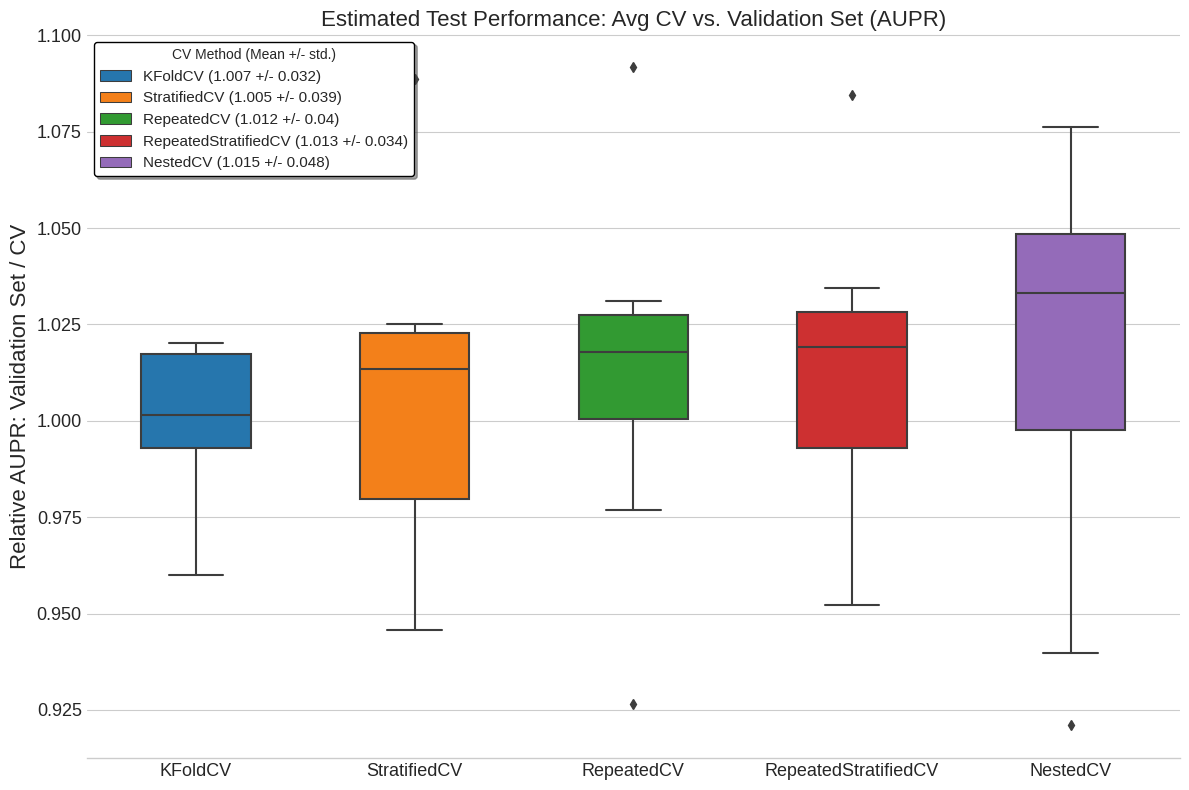

In [46]:
# plot validation vs. CV AUPR results from 5-fold CV over 10 trials
plt.style.reload_library()
plt.style.use('default')
plt.style.use('seaborn-whitegrid')
#plt.style.use('bmh')

plt.figure(figsize=(12, 8))
plt.subplot(111)
sns.boxplot(data=plot_avg_aupr_long, x='Method', y='Val_Relative_Avg_CV_AUPR', hue='Label', dodge=False,
            width=0.5, whis=1.5, linewidth=1.5, palette='tab10', saturation=0.9)
sns.despine(left=True)
plt.legend(frameon=True, edgecolor='black', shadow=True, fontsize=11, title='CV Method (Mean +/- std.)',
           facecolor='white')
plt.xticks(size=13)
plt.yticks(size=13)
plt.xlabel('')
plt.ylabel('Relative AUPR: Validation Set / CV', size=16)
plt.title('Estimated Test Performance: Avg CV vs. Validation Set (AUPR)', size=16)
plt.tight_layout()
#plt.savefig('../plots/Mortality/MORTALITY_AVG_CV_VS_VALIDATION_SET_AUPR_BOXPLOTS_10_TRIALS.png', dpi=300)
plt.show();

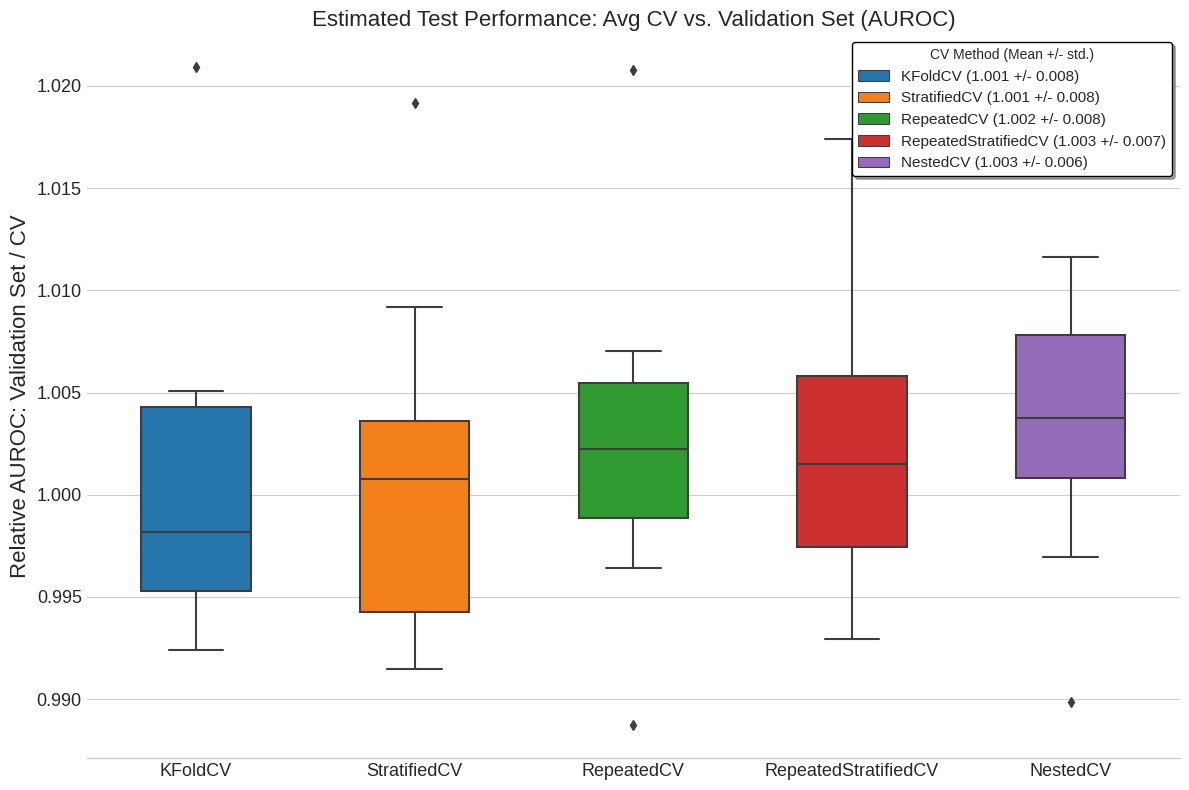

In [47]:
# plot validation vs. CV AUROC results from 5-fold CV over 10 trials
plt.style.reload_library()
plt.style.use('default')
plt.style.use('seaborn-whitegrid')
#plt.style.use('bmh')

plt.figure(figsize=(12, 8))
plt.subplot(111)
sns.boxplot(data=plot_avg_auroc_long, x='Method', y='Val_Relative_Avg_CV_AUROC', hue='Label', dodge=False,
            width=0.5, whis=1.5, linewidth=1.5, palette='tab10', saturation=0.9)
sns.despine(left=True)
plt.legend(frameon=True, edgecolor='black', shadow=True, fontsize=11, title='CV Method (Mean +/- std.)',
           facecolor='white')
plt.xticks(size=13)
plt.yticks(size=13)
plt.xlabel('')
plt.ylabel('Relative AUROC: Validation Set / CV', size=16)
plt.title('Estimated Test Performance: Avg CV vs. Validation Set (AUROC)', size=16)
plt.tight_layout()
#plt.savefig('../plots/Mortality/MORTALITY_AVG_CV_VS_VALIDATION_SET_AUROC_BOXPLOTS_10_TRIALS.png', dpi=300)
plt.show();

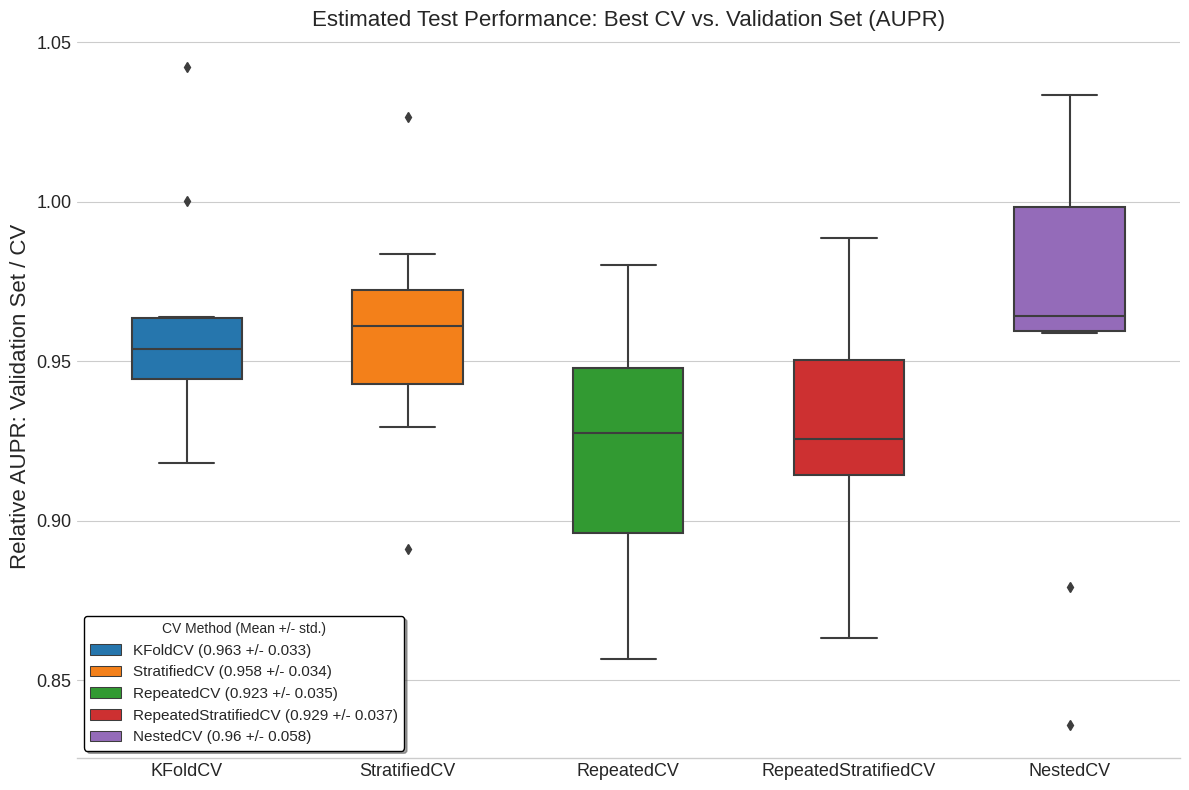

In [48]:
# plot validation vs. Best CV AUPR results from 5-fold CV over 10 trials
plt.style.reload_library()
plt.style.use('default')
plt.style.use('seaborn-whitegrid')
#plt.style.use('bmh')

plt.figure(figsize=(12, 8))
plt.subplot(111)
sns.boxplot(data=plot_best_aupr_long, x='Method', y='Val_Relative_Best_CV_AUPR', hue='Label', dodge=False,
            width=0.5, whis=1.5, linewidth=1.5, palette='tab10', saturation=0.9)
sns.despine(left=True)
plt.legend(frameon=True, edgecolor='black', shadow=True, fontsize=11, title='CV Method (Mean +/- std.)',
           facecolor='white')
plt.xticks(size=13)
plt.yticks(size=13)
plt.xlabel('')
plt.ylabel('Relative AUPR: Validation Set / CV', size=16)
plt.title('Estimated Test Performance: Best CV vs. Validation Set (AUPR)', size=16)
plt.tight_layout()
#plt.savefig('../plots/Mortality/MORTALITY_BEST_CV_VS_VALIDATION_SET_AUPR_BOXPLOTS_10_TRIALS.png', dpi=300)
plt.show();

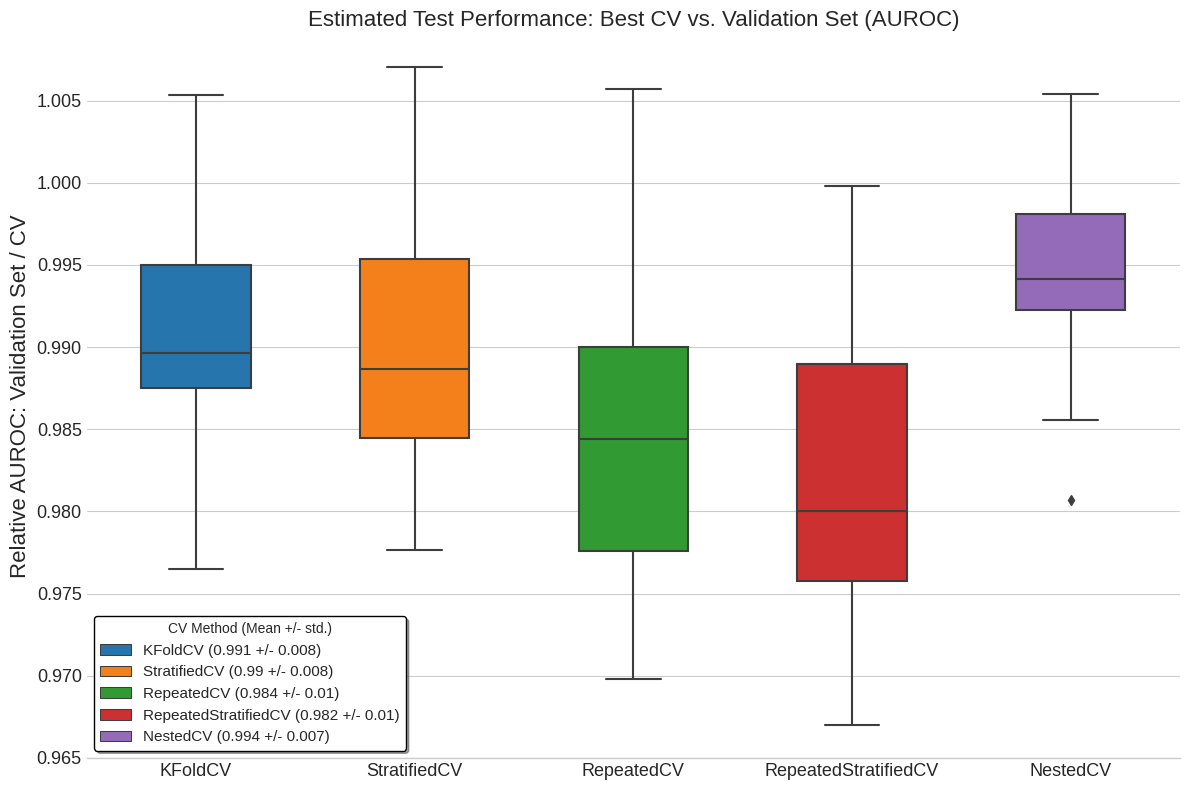

In [49]:
# plot validation vs. Best CV AUROC results from 5-fold CV over 10 trials
plt.style.reload_library()
plt.style.use('default')
plt.style.use('seaborn-whitegrid')
#plt.style.use('bmh')

plt.figure(figsize=(12, 8))
plt.subplot(111)
sns.boxplot(data=plot_best_auroc_long, x='Method', y='Val_Relative_Best_CV_AUROC', hue='Label', dodge=False,
            width=0.5, whis=1.5, linewidth=1.5, palette='tab10', saturation=0.9)
sns.despine(left=True)
plt.legend(frameon=True, edgecolor='black', shadow=True, fontsize=11, title='CV Method (Mean +/- std.)',
           facecolor='white')
plt.xticks(size=13)
plt.yticks(size=13)
plt.xlabel('')
plt.ylabel('Relative AUROC: Validation Set / CV', size=16)
plt.title('Estimated Test Performance: Best CV vs. Validation Set (AUROC)', size=16)
plt.tight_layout()
#plt.savefig('../plots/Mortality/MORTALITY_BEST_CV_VS_VALIDATION_SET_AUROC_BOXPLOTS_10_TRIALS.png', dpi=300)
plt.show();

### Save final optimism experiment data and run statistical test for difference in test error

In [57]:
# save repeated 5-fold optimism experiment to csv
cv_plot_metrics.head()
cv_val_results.head()
cv_val_results.shape
cv_val_results.to_csv('../plots/Mortality/MORTALITY_PREDICTION_REPEATED_5_FOLD_VALIDATION_VS_CV_ERROR_METRICS.csv')

,Metric,KFoldCV,StratifiedCV,RepeatedCV,RepeatedStratifiedCV,trial_num,NestedCV
0,Val_Relative_Avg_CV_AUPR,0.959963,0.945616,0.926490,0.952084,1,0.939856
1,Val_Relative_Avg_CV_AUROC,0.993207,0.992356,0.988724,0.992945,1,0.996975
2,Val_Relative_Best_CV_AUPR,0.942860,0.929352,0.856749,0.880746,1,0.879377
3,Val_Relative_Best_CV_AUROC,0.986919,0.977674,0.969824,0.969328,1,0.985576
4,Val_Relative_Avg_CV_AUPR,1.000801,1.024694,1.015915,1.019800,2,1.048802


,Metric,KFoldCV,StratifiedCV,RepeatedCV,RepeatedStratifiedCV,trial_num,NestedCV
0,CV_Best_AUPR,0.415253,0.416289,0.440490,0.440472,1,0.437024
1,CV_Best_AUROC,0.844158,0.850789,0.854280,0.858097,1,0.847011
2,CV_Best_Avg_AUPR,0.407855,0.409129,0.407333,0.407468,1,0.408902
3,CV_Best_Avg_AUROC,0.838813,0.838201,0.837950,0.837688,1,0.837326
4,Runtime,84.900918,82.737554,717.042853,715.740019,1,315.822449


(110, 7)

In [69]:
# try statistical test
from scipy.stats import wilcoxon, ranksums
metrics = ['CV_Best_AUPR', 'CV_Best_AUROC', 'CV_Best_Avg_AUPR',
       'CV_Best_Avg_AUROC', 'Val_AUPR', 'Val_AUROC',
       'Val_Relative_Avg_CV_AUPR', 'Val_Relative_Avg_CV_AUROC',
       'Val_Relative_Best_CV_AUPR', 'Val_Relative_Best_CV_AUROC']
for metric in metrics:
    print(metric)
    ncv_opt_vals = cv_val_results[cv_val_results.Metric==metric]['NestedCV'].values
    kfold_opt_vals = cv_val_results[cv_val_results.Metric==metric]['KFoldCV'].values
    w, p = wilcoxon(x=ncv_opt_vals, y=kfold_opt_vals)
    print('Wilcoxon: p = {}'.format(p))
    w, p = ranksums(x=ncv_opt_vals, y=kfold_opt_vals)
    print('Ranksums: p = {}'.format(p))
    print('\n')

CV_Best_AUPR
Wilcoxon: p = 0.76953125
Ranksums: p = 1.0


CV_Best_AUROC
Wilcoxon: p = 0.193359375
Ranksums: p = 0.17361733442494354


CV_Best_Avg_AUPR
Wilcoxon: p = 0.130859375
Ranksums: p = 0.15092695006671628


CV_Best_Avg_AUROC
Wilcoxon: p = 0.064453125
Ranksums: p = 0.019109922206844435


Val_AUPR
Wilcoxon: p = 0.4921875
Ranksums: p = 0.49629170223109287


Val_AUROC
Wilcoxon: p = 0.322265625
Ranksums: p = 0.49629170223109287


Val_Relative_Avg_CV_AUPR
Wilcoxon: p = 0.275390625
Ranksums: p = 0.3257513544787166


Val_Relative_Avg_CV_AUROC
Wilcoxon: p = 0.130859375
Ranksums: p = 0.25683925795785656


Val_Relative_Best_CV_AUPR
Wilcoxon: p = 0.4921875
Ranksums: p = 0.3643461266335529


Val_Relative_Best_CV_AUROC
Wilcoxon: p = 0.431640625
Ranksums: p = 0.28991845394256976




Val_Relative_Avg_CV_AUPR
Val_Relative_Avg_CV_AUROC
Val_Relative_Best_CV_AUPR
Val_Relative_Best_CV_AUROC


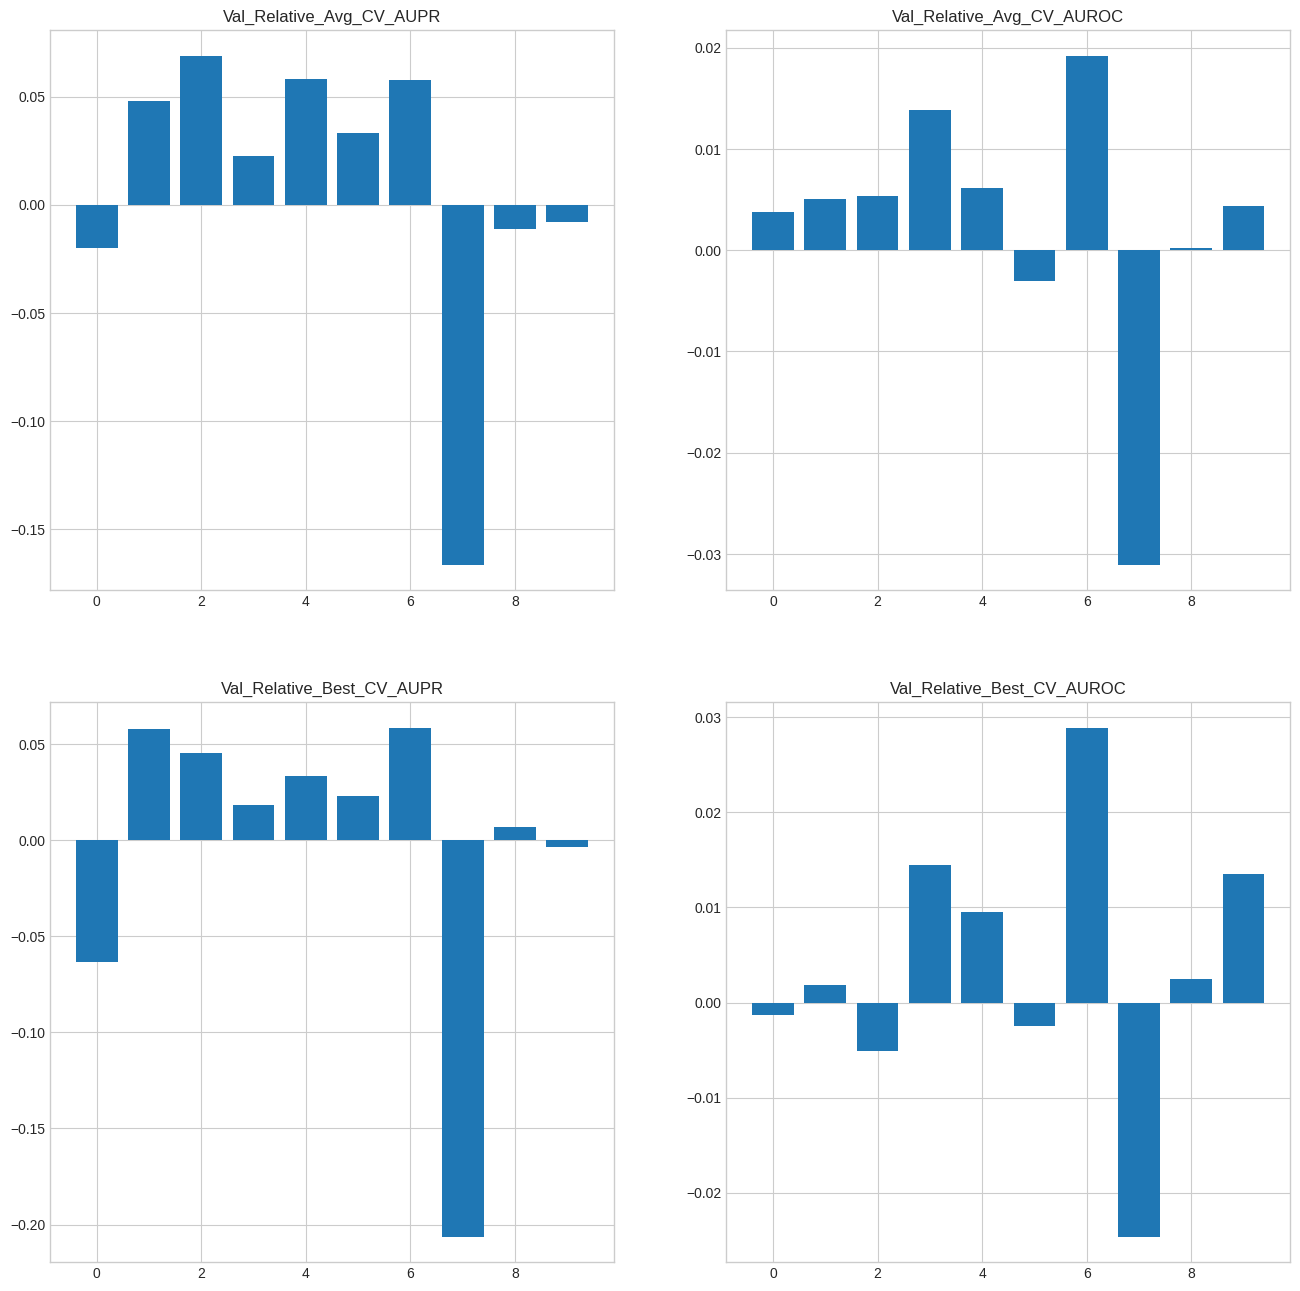

In [84]:
opt_metrics = ['Val_Relative_Avg_CV_AUPR', 'Val_Relative_Avg_CV_AUROC',
               'Val_Relative_Best_CV_AUPR', 'Val_Relative_Best_CV_AUROC']
plt.figure(figsize=(16,16))
i = 1
optimism_dict = {}
for opt in opt_metrics:
    print(opt)
    ax = plt.subplot(2, 2, i)
    ncv_opt_vals = cv_val_results[cv_val_results.Metric==opt]['NestedCV'].values
    kfold_opt_vals = cv_val_results[cv_val_results.Metric==opt]['KFoldCV'].values
    ax = plt.bar(x = np.arange(len(ncv_opt_vals)), height = ncv_opt_vals - kfold_opt_vals, label=opt)
    plt.title(opt)
    i+=1
plt.show();

In [98]:
# # get mean/stats for repeated optimism error
# for opt in opt_metrics:
#     print(opt)
#     ncv_opt_vals = cv_val_results[cv_val_results.Metric==opt]['NestedCV'].values
#     kfold_opt_vals = cv_val_results[cv_val_results.Metric==opt]['KFoldCV'].values
cv_val_results.groupby('Metric')['KFoldCV'].agg([np.mean, np.median, np.std]).reset_index().iloc[7:11]
cv_val_results.groupby('Metric')['NestedCV'].agg([np.mean, np.median, np.std]).reset_index().iloc[7:11]

,Metric,mean,median,std
7,Val_Relative_Avg_CV_AUPR,1.007005,1.001425,0.033794
8,Val_Relative_Avg_CV_AUROC,1.000770,0.998173,0.008434
9,Val_Relative_Best_CV_AUPR,0.962941,0.953923,0.034751
10,Val_Relative_Best_CV_AUROC,0.990628,0.989631,0.008155


,Metric,mean,median,std
7,Val_Relative_Avg_CV_AUPR,1.015289,1.033140,0.050415
8,Val_Relative_Avg_CV_AUROC,1.003157,1.003763,0.006482
9,Val_Relative_Best_CV_AUPR,0.959904,0.964299,0.061115
10,Val_Relative_Best_CV_AUROC,0.994345,0.994123,0.007557


### Explore Other Ways of Visualizing CV vs. Validation Scores

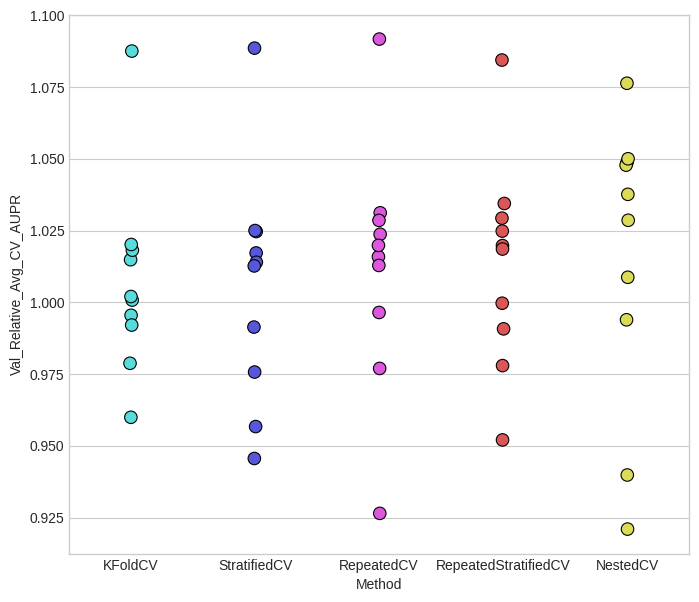

In [85]:
plt.figure(figsize=(8, 7))
ax = plt.gca()
sns.stripplot(data=plot_avg_aupr_long, x='Method', y='Val_Relative_Avg_CV_AUPR',
              ax=ax, size=9, jitter=0.01, edgecolor='black', linewidth=0.8, palette=sns.hls_palette(h=.5))
plt.show();

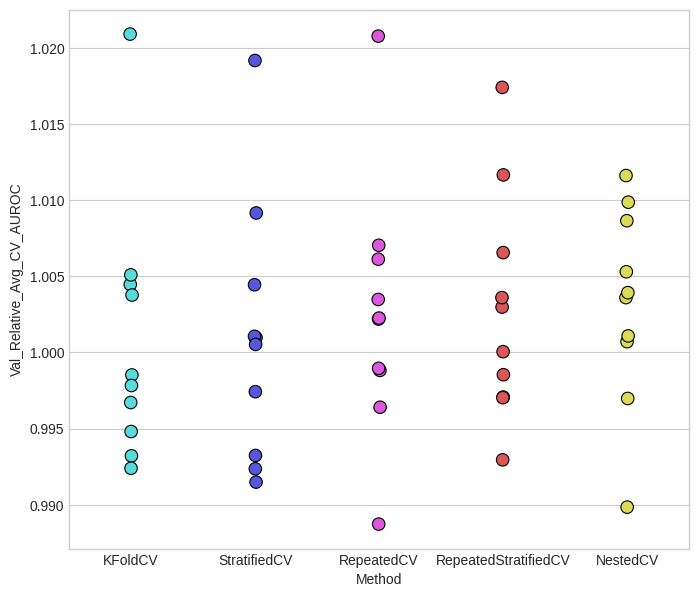

In [86]:
plt.figure(figsize=(8, 7))
ax = plt.gca()
sns.stripplot(data=plot_avg_auroc_long, x='Method', y='Val_Relative_Avg_CV_AUROC',
              ax=ax, size=9, jitter=0.01, edgecolor='black', linewidth=0.8, palette=sns.hls_palette(h=.5))
plt.show();

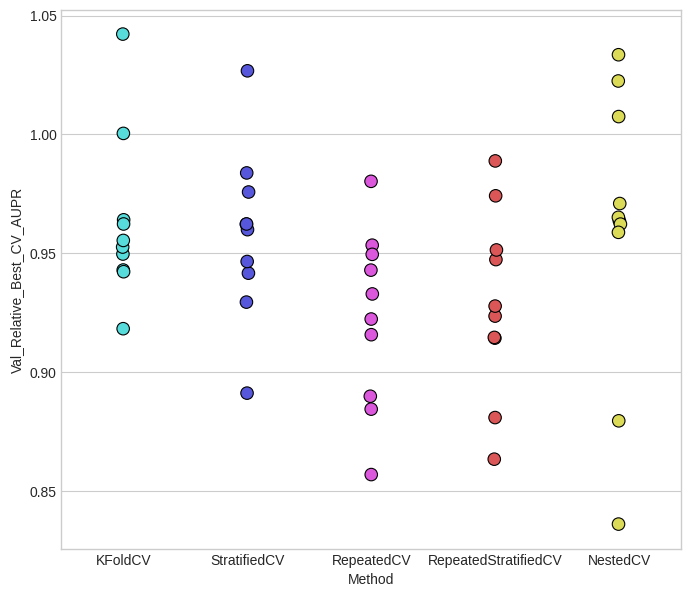

In [87]:
plt.figure(figsize=(8, 7))
ax = plt.gca()
sns.stripplot(data=plot_best_aupr_long, x='Method', y='Val_Relative_Best_CV_AUPR',
              ax=ax, size=9, jitter=0.01, edgecolor='black', linewidth=0.8, palette=sns.hls_palette(h=.5))
plt.show();

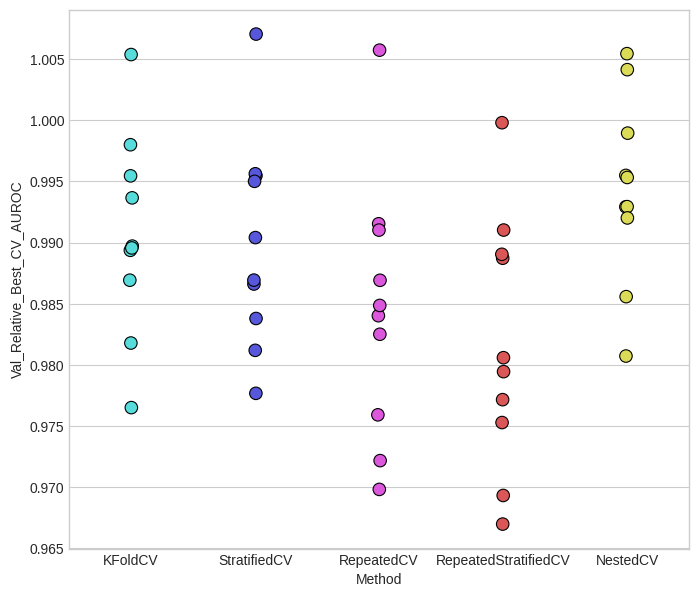

In [88]:
plt.figure(figsize=(8, 7))
ax = plt.gca()
sns.stripplot(data=plot_best_auroc_long, x='Method', y='Val_Relative_Best_CV_AUROC',
              ax=ax, size=9, jitter=0.01, edgecolor='black', linewidth=0.8, palette=sns.hls_palette(h=.5))
plt.show();

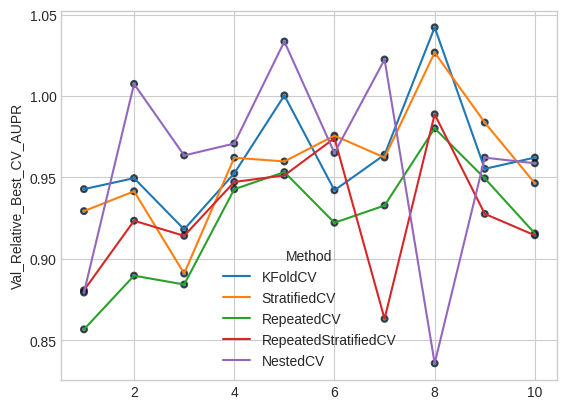

In [89]:
sns.lineplot(data=plot_best_aupr_long, y='Val_Relative_Best_CV_AUPR', x=np.tile(np.arange(1, 11, 1), 5),
             hue='Method', markers=True, linewidth=1.5, dashes=True)
sns.scatterplot(data=plot_best_aupr_long, y='Val_Relative_Best_CV_AUPR', x=np.tile(np.arange(1, 11, 1), 5),
                legend=False, size=60, alpha=0.7, linewidth=1.5, palette='bright6',
                edgecolor='black')
plt.show();